In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
# Load your data (example placeholder)
data = pd.read_json('stop_phase_gps_data.json')

# Function to calculate distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    distance = haversine((lat1,lon1),(lat2,lon2), unit=Unit.METERS)

# Calculate center of cluster
def get_cluster_center(df):
    return df['latitude'].mean(), df['longitude'].mean()

# Filter Scattered Points in Stop Phase
def filter_scatter(df, radius_threshold=20):
    center_lat, center_lon = get_cluster_center(df)
    df['distance_to_center'] = df.apply(
        lambda row: haversine_distance(row['latitude'], row['longitude'], center_lat, center_lon), axis=1
    )
    return df[df['distance_to_center'] <= radius_threshold]

# Visualize the filtering result
def plot_gps_points(original_df, filtered_df):
    plt.figure(figsize=(10, 8))
    plt.scatter(original_df['longitude'], original_df['latitude'], label='Raw Data', alpha=0.5)
    plt.scatter(filtered_df['longitude'], filtered_df['latitude'], label='Filtered Data', color='red')
    plt.legend()
    plt.title('GPS Scatter Filter')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# --- Example Usage ---
# Assuming you know the stop phase time range:
stop_phase_df = data[(data['timestamp'] >= '2025-04-01T08:03:06') & (data['timestamp'] <= '2025-04-01T09:00:44')]
filtered_df = filter_scatter(stop_phase_df)

plot_gps_points(stop_phase_df, filtered_df)

# You can extend this with DBSCAN or rolling median filtering if you want to filter without knowing the stop phase.


ModuleNotFoundError: No module named 'pandas'

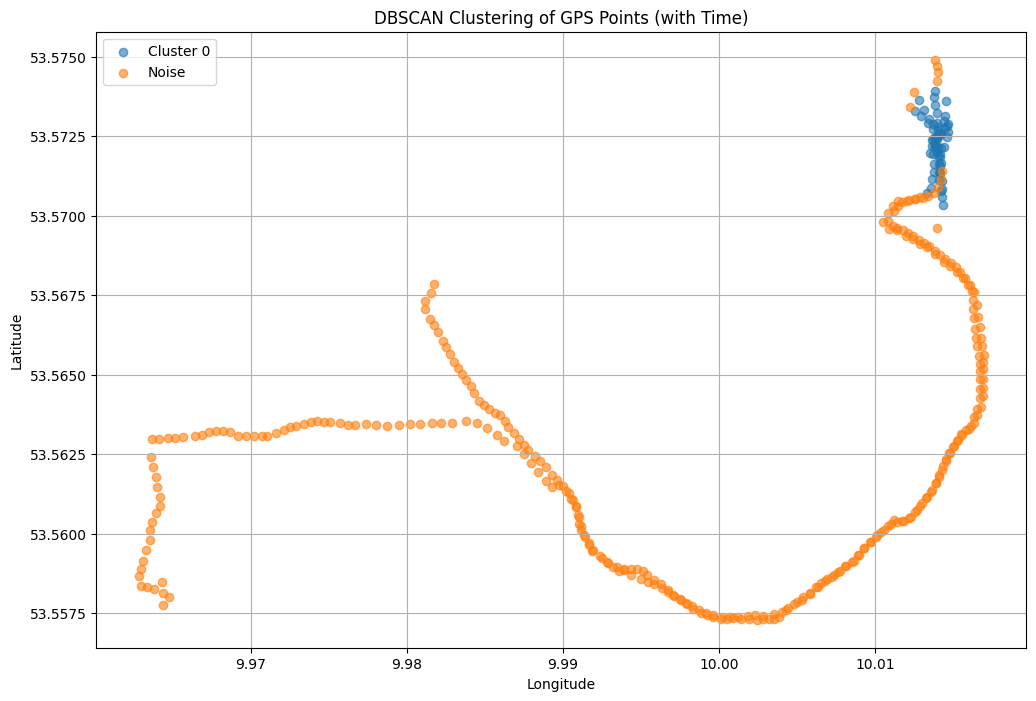

In [56]:
import json
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reload the data
file_path = 'stop_phase_gps_data.json'
with open(file_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_seconds'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

# Feature array
X = df[['latitude', 'longitude', 'time_seconds']].to_numpy()

# DBSCAN parameters
eps = 0.0009
# roughly 50 meters in lat/lon degrees
time_eps = 9000  # 15 minutes in seconds

# Normalize time feature to match spatial scale (optional and simple scaling here)
X[:, 2] = X[:, 2] * 6/ time_eps * eps

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=10)
df['cluster'] = dbscan.fit_predict(X)

# Visualize
plt.figure(figsize=(12, 8))
unique_clusters = set(df['cluster'])
for cluster in unique_clusters:
    cluster_points = df[df['cluster'] == cluster]
    plt.scatter(cluster_points['longitude'], cluster_points['latitude'], label=f'Cluster {cluster}' if cluster != -1 else 'Noise', alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of GPS Points (with Time)')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from datetime import timedelta
import folium

In [59]:
# Load the data
file_path = 'stop_phase_gps_data.json'
with open(file_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame and preprocess
df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True) # Ensure data is sorted

df.head()

,altitude,processed_at,longitude,id,latitude,quality,timestamp
0,92.60,2025-04-01T09:52:10.978803,9.964738,vehicle_01,53.55800,1.0,2025-04-01 07:45:06
1,120.40,2025-04-01T09:52:14.223584,9.964364,vehicle_01,53.55774,1.0,2025-04-01 07:45:11
2,133.51,2025-04-01T09:52:19.173109,9.964406,vehicle_01,53.55813,6.0,2025-04-01 07:45:21
3,116.97,2025-04-01T09:52:23.801090,9.964314,vehicle_01,53.55848,1.0,2025-04-01 07:45:28
4,66.49,2025-04-01T09:52:28.646948,9.963786,vehicle_01,53.55827,1.0,2025-04-01 07:45:33


In [95]:
# Calculate median of the next `median_n` rows
median_n = 18
df['next_n_median_longitude'] = df['longitude'].apply(
    lambda x: None  # placeholder, will be overwritten
)
df['next_n_median_latitude'] = df['latitude'].apply(
    lambda x: None  # placeholder, will be overwritten
)

for i in range(len(df)):
    df.loc[i, 'next_n_median_longitude'] = df['longitude'].iloc[i+1:i+1+median_n].median()
    df.loc[i, 'next_n_median_latitude'] = df['latitude'].iloc[i+1:i+1+median_n].median()
print(median_n)
df.tail()



18


,altitude,processed_at,longitude,id,latitude,quality,timestamp,next_n_median_longitude,next_n_median_latitude
383,16.13,2025-04-01T10:15:16.047011,9.981500,vehicle_01,53.56676,1.0,2025-04-01 09:19:34,9.981367,53.567445
384,17.46,2025-04-01T10:15:19.328050,9.981184,vehicle_01,53.56706,1.0,2025-04-01 09:19:44,9.98155,53.56757
385,21.03,2025-04-01T10:15:22.241365,9.981165,vehicle_01,53.56732,1.0,2025-04-01 09:19:55,9.981648,53.56771
386,21.64,2025-04-01T10:15:25.393825,9.981550,vehicle_01,53.56757,1.0,2025-04-01 09:20:06,9.981746,53.56785
387,26.40,2025-04-01T10:15:28.125136,9.981746,vehicle_01,53.56785,1.0,2025-04-01 09:20:44,NaN,NaN


In [100]:
# --- Configuration ---
stop_distance_threshold_meters = 140  # Max distance (meters) between points to be considered 'stopped'
min_stop_duration_seconds = 10 * 60 # Minimum duration (seconds) for a stop to be cleaned

# --- Algorithm ---
cleaned_data = []
i = 0
n = len(df)

while i < n:
    current_point = df.iloc[i]
    
    # Start checking for a stop from the next point
    j = i + 1
    stop_candidates = [current_point] # Current point is always the start of a potential stop/movement
    
    # Find consecutive points within the distance threshold of the *start* point
    while j < n:
        next_point = df.iloc[j]
        
        distance = haversine(
            (current_point['next_n_median_latitude'], current_point['next_n_median_longitude']),
            (next_point['next_n_median_latitude'], next_point['next_n_median_longitude']),
            unit=Unit.METERS
        )
        
        if distance < stop_distance_threshold_meters:
            stop_candidates.append(next_point)
            j += 1
        else:
            break # Movement detected, stop sequence ends
            
    # Evaluate the identified sequence (stop_candidates)
    if len(stop_candidates) > 1: # We found at least one subsequent point that was 'stopped'
        start_time = stop_candidates[0]['timestamp']
        end_time = stop_candidates[-1]['timestamp']
        duration = (end_time - start_time).total_seconds()
        
        if duration >= min_stop_duration_seconds:
            # Long stop: Keep only the first point
            cleaned_data.append(stop_candidates[0])
            # Move the main index past all points in this long stop
            i = j 
        else:
            # Short stop or just noise: Keep all points in the sequence
            cleaned_data.extend(stop_candidates)
            # Move the main index past all points in this sequence
            i = j 
    else: 
        # No stop detected starting at current_point, just keep current_point and move to the next
        cleaned_data.append(current_point)
        i += 1

# Create the final cleaned DataFrame
cleaned_df = pd.DataFrame(cleaned_data).reset_index(drop=True)

In [101]:
# Display results
print(f"Original number of points: {len(df)}")
print(f"Cleaned number of points: {len(cleaned_df)}")
cleaned_df.tail()

Original number of points: 388
Cleaned number of points: 322


,altitude,processed_at,longitude,id,latitude,quality,timestamp,next_n_median_longitude,next_n_median_latitude
317,16.13,2025-04-01T10:15:16.047011,9.981500,vehicle_01,53.56676,1.0,2025-04-01 09:19:34,9.981367,53.567445
318,17.46,2025-04-01T10:15:19.328050,9.981184,vehicle_01,53.56706,1.0,2025-04-01 09:19:44,9.981550,53.567570
319,21.03,2025-04-01T10:15:22.241365,9.981165,vehicle_01,53.56732,1.0,2025-04-01 09:19:55,9.981648,53.567710
320,21.64,2025-04-01T10:15:25.393825,9.981550,vehicle_01,53.56757,1.0,2025-04-01 09:20:06,9.981746,53.567850
321,26.40,2025-04-01T10:15:28.125136,9.981746,vehicle_01,53.56785,1.0,2025-04-01 09:20:44,NaN,NaN


In [74]:
center = [df['latitude'].mean(), df['longitude'].mean()]

In [102]:
m = folium.Map(location=center, zoom_start=14)
# Add points to the map
for idx, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row.get('label', f"Point {idx}"),
        tooltip=row.get('label', f"Point {idx}")
    ).add_to(m)
df_median_cleaned = df.dropna(subset=['next_n_median_latitude', 'next_n_median_longitude'])
for idx, row in df_median_cleaned.iterrows():
    folium.Marker(
        location=[row['next_n_median_latitude'], row['next_n_median_longitude']],
        popup=row.get('label', f"Median Point {idx}"),
        icon=folium.Icon(color='red', icon='info-sign'),
        tooltip=row.get('label', f"Median Point {idx}")
    ).add_to(m)
coordinates = df[['latitude', 'longitude']].values.tolist()
folium.PolyLine(locations=coordinates, color='blue', weight=3).add_to(m)
cleaned_coordinates = cleaned_df[['latitude','longitude']].values.tolist()
folium.PolyLine(locations=cleaned_coordinates, color='purple', weight=3).add_to(m)
m

In [106]:
m = folium.Map(location=center, zoom_start=14)


for idx, row in cleaned_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row.get('label', f"Median Point {idx}"),
        icon=folium.Icon(color='red', icon='info-sign'),
        tooltip=row.get('label', f"Median Point {idx}")
    ).add_to(m)
cleaned_coordinates = cleaned_df[['latitude','longitude']].values.tolist()
folium.PolyLine(locations=cleaned_coordinates, color='purple', weight=3).add_to(m)
m